# **CYCLONE INTENSITY ESTIMATION EDAI PROJECT**

**Mounting With Drive**

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Reading CSV file**

In [21]:
import pandas as pd
pd.read_csv('/content/drive/MyDrive/EDAI/insat_3d_ds - Sheet.csv')

img_name  label
0       25.jpg     25
1       27.jpg     27
2       28.jpg     28
3       30.jpg     30
4    30(1).jpg     30
..         ...    ...
131    112.jpg    112
132    115.jpg    115
133    118.jpg    118
134    119.jpg    119
135    128.jpg    128

[136 rows x 2 columns]

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Dense,Flatten

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2,Xception,InceptionV3,VGG16

import warnings
import glob
warnings.filterwarnings("ignore")

**Visualizing the Dataset**

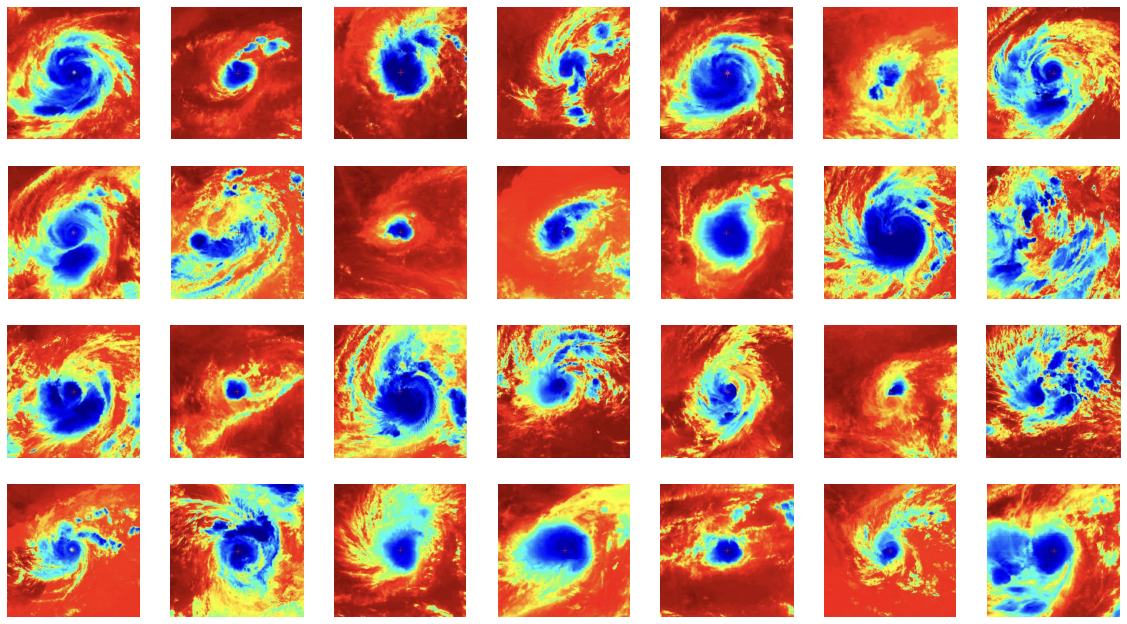

In [7]:
paths = glob.glob("/content/drive/MyDrive/EDAI/CYCLONE_DATASET_INFRARED/*.jpg")
plt.figure(figsize=(20, 20))
for i in range(28):
    cur_img = mpimg.imread(paths[i]) 
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(cur_img.astype("uint8"))
    plt.axis("off")

Preparation of Model using CNN Architectures 

In [52]:
train = pd.read_csv("/content/drive/MyDrive/EDAI/insat_3d_ds - Sheet.csv", nrows=100)
val = pd.read_csv("/content/drive/MyDrive/EDAI/insat_3d_ds - Sheet_val.csv", nrows=36)

In [53]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [54]:
train_data = train_datagen.flow_from_dataframe(train,directory="/content/drive/MyDrive/EDAI/CYCLONE_DATASET_INFRARED",subset="training",
                                               x_col="img_name",y_col="label",target_size=(512, 512),batch_size=16,class_mode='raw')



Found 100 validated image filenames.


In [55]:
val_data = train_datagen.flow_from_dataframe(val,directory="/content/drive/MyDrive/EDAI/CYCLONE_DATASET_INFRARED",subset="validation",
                                              x_col="img_name",y_col="label",target_size=(512, 512),batch_size=16,class_mode='raw')

Found 36 validated image filenames.


InceptionV3

In [84]:
from tensorflow.keras.applications import InceptionV3

In [85]:
def build_model():
    base = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(512, 512, 3)))

    base.trainable = False

    flatten = base.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(64, activation="relu")(flatten)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(1, activation="linear")(bboxHead)

    model = Model(inputs=base.input, outputs=bboxHead)
    
    return model

In [86]:
model = build_model()

In [87]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 255, 255, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 255, 255, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [88]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])

save_best = tf.keras.callbacks.ModelCheckpoint("InceptionV3.h5", monitor='loss',save_best_only=True, verbose=1)

In [89]:
history1=model.fit(train_data,validation_data=val_data, epochs=50, callbacks=[save_best])

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 54.4457 - root_mean_squared_error: 63.9488 - mean_squared_error: 4089.4468 - mean_absolute_error: 54.4457
Epoch 1: loss improved from inf to 54.44570, saving model to InceptionV3.h5
7/7 [==============================] - 9s 769ms/step - loss: 54.4457 - root_mean_squared_error: 63.9488 - mean_squared_error: 4089.4468 - mean_absolute_error: 54.4457 - val_loss: 75.4224 - val_root_mean_squared_error: 76.9553 - val_mean_squared_error: 5922.1260 - val_mean_absolute_error: 75.4224
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 17.7777 - root_mean_squared_error: 22.2845 - mean_squared_error: 496.5993 - mean_absolute_error: 17.7777
Epoch 2: loss improved from 54.44570 to 17.77770, saving model to InceptionV3.h5
7/7 [==============================] - 4s 598ms/step - loss: 17.7777 - root_mean_squared_error: 22.2845 - mean_squared_error: 496.5993 - mean_absolute_error: 17.7777 - val_loss: 38.0658 - val_root_mean_s

In [90]:
model = tf.keras.models.load_model('/content/InceptionV3.h5')
model.evaluate(train_data)

7/7 [==============================] - 3s 165ms/step - loss: 1.6502 - root_mean_squared_error: 2.2420 - mean_squared_error: 5.0265 - mean_absolute_error: 1.6502


[1.6501545906066895, 2.241978406906128, 5.026467800140381, 1.6501545906066895]

In [66]:
pred = model.predict(train_data, verbose=1).round(2)

7/7 [==============================] - 2s 185ms/step


In [68]:
pred

array([[ 45.32],
       [ 46.66],
       [ 67.86],
       [ 63.23],
       [ 48.05],
       [ 31.14],
       [ 54.21],
       [ 47.63],
       [ 53.96],
       [ 52.44],
       [ 54.86],
       [ 59.19],
       [ 64.42],
       [ 74.3 ],
       [ 60.76],
       [ 55.23],
       [ 33.19],
       [ 56.94],
       [ 54.38],
       [ 57.92],
       [ 54.6 ],
       [ 59.75],
       [ 49.72],
       [ 49.36],
       [ 71.05],
       [ 50.91],
       [ 70.45],
       [ 40.84],
       [ 48.  ],
       [ 46.71],
       [ 45.9 ],
       [ 59.62],
       [ 35.69],
       [ 52.  ],
       [ 58.49],
       [ 42.68],
       [ 60.  ],
       [ 49.78],
       [ 71.11],
       [ 57.3 ],
       [ 52.08],
       [ 48.7 ],
       [ 44.54],
       [ 54.12],
       [ 47.56],
       [ 66.01],
       [ 46.07],
       [ 73.42],
       [ 53.8 ],
       [ 62.28],
       [ 61.36],
       [ 54.95],
       [ 55.72],
       [ 52.57],
       [ 58.7 ],
       [ 54.47],
       [ 35.26],
       [ 58.3 ],
       [ 35.02

In [97]:
train = [[25],[26],[27],[28],[29],[30],[31],[32],[33],[34],[35],[36],[37],[38],[39],[40],[41],[42],[43],[44],[45],[46],[47],[48],[49],[50],[51],[52],[53],[54],[55],[56],[57],[58],[59],[60],[61],[62],[63],[64],[65],[66],[67],[68],[69],[70],[71],[72],[73],[74],[75],[76],[77],[78],[79],[80],[81],[82],[83],[84],[85],[86],[87],[88],[89],[90],[91],[92],[93],[94],[95],[96],[97],[98],[99],[100],[101],[102],[103],[104],[105],[106],[107],[108],[109],[110],[111],[112],[113],[114],[115],[116],[117],[118],[119],[120],[121],[122],[123],[124]]
train

[[25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [124]]

In [102]:
from sklearn.metrics import r2_score
r2_score(train, pred)

0.6371722566751203


In [106]:
import matplotlib.pyplot as plt
rmse = history1.history['root_mean_squared_error']
# val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
# val_loss = history1.history['val_loss']

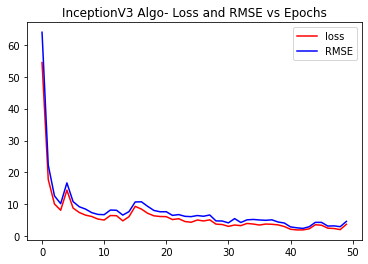

<Figure size 432x288 with 0 Axes>

In [108]:
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='loss')
# plt.plot(epochs, root_mean_squared_error, 'b', label='Validation accuracy')
plt.plot(epochs, rmse, 'b', label='RMSE')
# plt.title("Xception Algortihm")
plt.title('InceptionV3 Algo- Loss and RMSE vs Epochs')
plt.legend()
plt.figure()

plt.show()

VGG16

In [109]:
from tensorflow.keras.applications import VGG16

In [110]:
def build_model():
    base = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(512, 512, 3)))

    base.trainable = False

    flatten = base.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(64, activation="relu")(flatten)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(1, activation="linear")(bboxHead)

    model = Model(inputs=base.input, outputs=bboxHead)
    
    return model

In [105]:
model = build_model()

58889256/58889256 [==============================] - 0s 0us/step


In [111]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0   

In [112]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/EDAI/model1/VGG16.h5", monitor='loss',save_best_only=True, verbose=1)

In [113]:
history2=model.fit(train_data,validation_data=val_data, epochs=50, callbacks=[save_best])

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 15.4154 - root_mean_squared_error: 19.9772 - mean_squared_error: 399.0889 - mean_absolute_error: 15.4154
Epoch 1: loss improved from inf to 15.41540, saving model to /content/drive/MyDrive/EDAI/model1/VGG16.h5
7/7 [==============================] - 14s 2s/step - loss: 15.4154 - root_mean_squared_error: 19.9772 - mean_squared_error: 399.0889 - mean_absolute_error: 15.4154 - val_loss: 41.1511 - val_root_mean_squared_error: 44.0472 - val_mean_squared_error: 1940.1567 - val_mean_absolute_error: 41.1511
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 9.7546 - root_mean_squared_error: 12.3377 - mean_squared_error: 152.2182 - mean_absolute_error: 9.7546
Epoch 2: loss improved from 15.41540 to 9.75464, saving model to /content/drive/MyDrive/EDAI/model1/VGG16.h5
7/7 [==============================] - 4s 588ms/step - loss: 9.7546 - root_mean_squared_error: 12.3377 - mean_squared_error: 152.2182 - mean_absolute_er

In [114]:
model = tf.keras.models.load_model('/content/drive/MyDrive/EDAI/model1/VGG16.h5')
model.evaluate(train_data)

7/7 [==============================] - 3s 329ms/step - loss: 1.1173 - root_mean_squared_error: 1.3940 - mean_squared_error: 1.9434 - mean_absolute_error: 1.1173


[1.1173359155654907,
 1.3940483331680298,
 1.9433706998825073,
 1.1173359155654907]

In [115]:
pred = model.predict(train_data, verbose=1).round(2)

7/7 [==============================] - 2s 371ms/step


In [118]:
from sklearn.metrics import r2_score
r2_score(train, pred)

0.8332801205356086


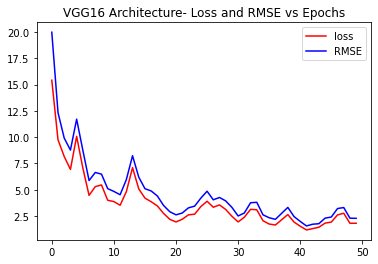

<Figure size 432x288 with 0 Axes>

In [119]:
import matplotlib.pyplot as plt
rmse = history2.history['root_mean_squared_error']
# val_acc = history1.history['val_accuracy']
loss = history2.history['loss']
# val_loss = history1.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='loss')
# plt.plot(epochs, root_mean_squared_error, 'b', label='Validation accuracy')
plt.plot(epochs, rmse, 'b', label='RMSE')
# plt.title("Xception Algortihm")
plt.title('VGG16 Architecture- Loss and RMSE vs Epochs')
plt.legend()
plt.figure()


plt.show()

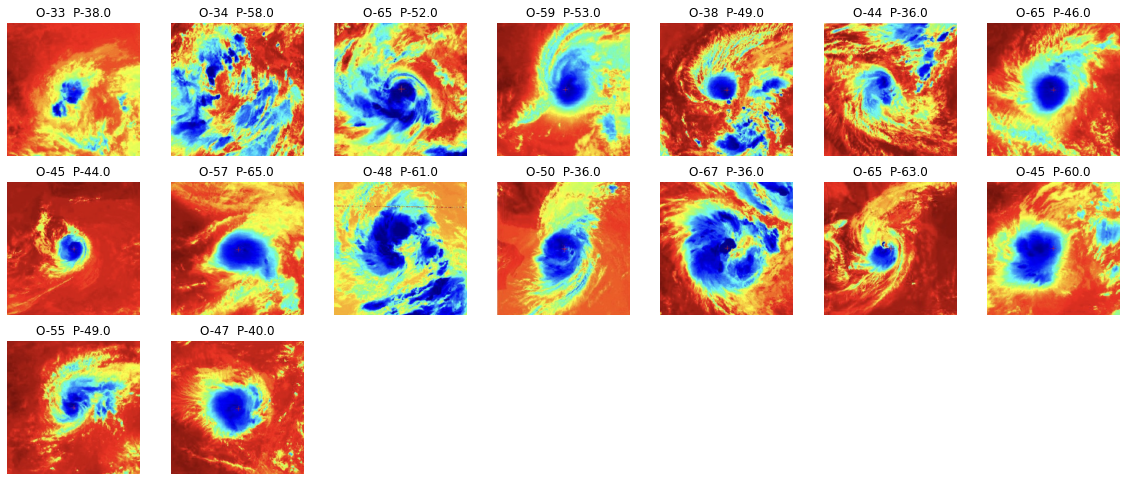

In [120]:
plt.figure(figsize=(20, 20))
for i in range(16):
    cur_img = train_data[0][0][i]
    ax = plt.subplot(7, 7, i + 1)
    plt.title("O-"+str(train_data[0][1][i])+"  P-"+str(pred[i][0].round()))
    plt.imshow(cur_img)
    plt.axis("off")

**MobileNetV2**

In [150]:
from tensorflow.keras.applications import MobileNetV2

In [151]:
def build_model():
    base = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(512, 512, 3)))

    base.trainable = False

    flatten = base.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(64, activation="relu")(flatten)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(1, activation="linear")(bboxHead)

    model = Model(inputs=base.input, outputs=bboxHead)
    
    return model

In [152]:
model = build_model()

In [153]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [154]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/EDAI/model1/MobileNetV2Model.h5", monitor='loss',save_best_only=True, verbose=1)

In [155]:
history3=model.fit(train_data,validation_data=val_data, epochs=50, callbacks=[save_best])

Epoch 1/50
6/7 [========================>.....] - ETA: 0s - loss: 75.3300 - root_mean_squared_error: 114.8956 - mean_squared_error: 13201.0088 - mean_absolute_error: 75.3300
Epoch 1: loss improved from inf to 72.80083, saving model to /content/drive/MyDrive/EDAI/model1/MobileNetV2Model.h5
7/7 [==============================] - 6s 540ms/step - loss: 72.8008 - root_mean_squared_error: 112.6077 - mean_squared_error: 12680.4922 - mean_absolute_error: 72.8008 - val_loss: 34.2942 - val_root_mean_squared_error: 37.9215 - val_mean_squared_error: 1438.0365 - val_mean_absolute_error: 34.2942
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 14.6560 - root_mean_squared_error: 18.5410 - mean_squared_error: 343.7683 - mean_absolute_error: 14.6560
Epoch 2: loss improved from 72.80083 to 14.65603, saving model to /content/drive/MyDrive/EDAI/model1/MobileNetV2Model.h5
7/7 [==============================] - 4s 625ms/step - loss: 14.6560 - root_mean_squared_error: 18.5410 - mean_squared_

In [156]:
model = tf.keras.models.load_model('/content/drive/MyDrive/EDAI/model1/MobileNetV2Model.h5')
model.evaluate(train_data)

7/7 [==============================] - 2s 126ms/step - loss: 1.9532 - root_mean_squared_error: 2.8287 - mean_squared_error: 8.0016 - mean_absolute_error: 1.9532


[1.953153133392334, 2.8287158012390137, 8.001633644104004, 1.953153133392334]

In [157]:
pred3 = model.predict(train_data, verbose=1).round(2)

7/7 [==============================] - 2s 135ms/step


In [163]:
from sklearn.metrics import r2_score
r2_score(train, pred3)

0.8110963951979867

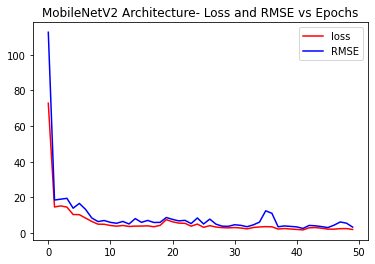

<Figure size 432x288 with 0 Axes>

In [208]:
import matplotlib.pyplot as plt
rmse = history3.history['root_mean_squared_error']
# val_acc = history1.history['val_accuracy']
loss = history3.history['loss']
# val_loss = history1.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='loss')
# plt.plot(epochs, root_mean_squared_error, 'b', label='Validation accuracy')
plt.plot(epochs, rmse, 'b', label='RMSE')
# plt.title("Xception Algortihm")
plt.title('MobileNetV2 Architecture- Loss and RMSE vs Epochs')
plt.legend()
plt.figure()


plt.show()

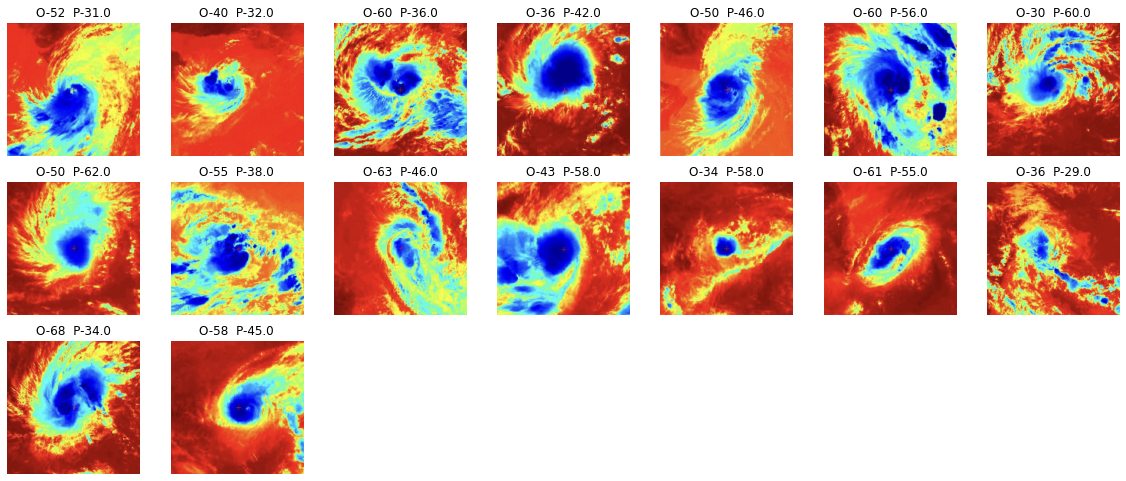

In [160]:
plt.figure(figsize=(20, 20))
for i in range(16):
    cur_img = train_data[0][0][i]
    ax = plt.subplot(7, 7, i + 1)
    plt.title("O-"+str(train_data[0][1][i])+"  P-"+str(pred3[i][0].round()))
    plt.imshow(cur_img)
    plt.axis("off")

Xception

In [164]:
from tensorflow.keras.applications import Xception

In [165]:
def build_model():
    base = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(512, 512, 3)))

    base.trainable = False

    flatten = base.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(64, activation="relu")(flatten)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(1, activation="linear")(bboxHead)

    model = Model(inputs=base.input, outputs=bboxHead)
    
    return model

In [166]:
model = build_model()

83683744/83683744 [==============================] - 0s 0us/step


In [167]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 255, 255, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 255, 255, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [168]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/EDAI/model1/Xception.h5", monitor='loss',save_best_only=True, verbose=1)

In [169]:
history4=model.fit(train_data,validation_data=val_data, epochs=50, callbacks=[save_best])

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 30.7357 - root_mean_squared_error: 36.4344 - mean_squared_error: 1327.4637 - mean_absolute_error: 30.7357
Epoch 1: loss improved from inf to 30.73568, saving model to /content/drive/MyDrive/EDAI/model1/Xception.h5
7/7 [==============================] - 10s 847ms/step - loss: 30.7357 - root_mean_squared_error: 36.4344 - mean_squared_error: 1327.4637 - mean_absolute_error: 30.7357
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 12.9562 - root_mean_squared_error: 15.5832 - mean_squared_error: 242.8364 - mean_absolute_error: 12.9562
Epoch 2: loss improved from 30.73568 to 12.95619, saving model to /content/drive/MyDrive/EDAI/model1/Xception.h5
7/7 [==============================] - 4s 615ms/step - loss: 12.9562 - root_mean_squared_error: 15.5832 - mean_squared_error: 242.8364 - mean_absolute_error: 12.9562
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 9.1842 - root_mean_squared_error: 11

In [170]:
model = tf.keras.models.load_model('/content/drive/MyDrive/EDAI/model1/Xception.h5')
model.evaluate(train_data)

7/7 [==============================] - 3s 281ms/step - loss: 1.3408 - root_mean_squared_error: 1.6976 - mean_squared_error: 2.8817 - mean_absolute_error: 1.3408


[1.3407645225524902,
 1.6975607872009277,
 2.8817126750946045,
 1.3407645225524902]

In [171]:
pred4 = model.predict(train_data, verbose=1).round(2)

7/7 [==============================] - 3s 315ms/step


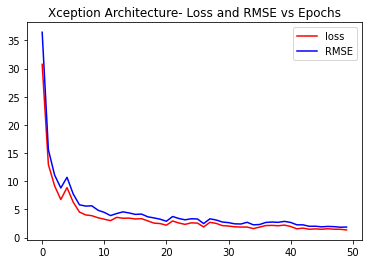

<Figure size 432x288 with 0 Axes>

In [174]:
import matplotlib.pyplot as plt
rmse = history4.history['root_mean_squared_error']
# val_acc = history1.history['val_accuracy']
loss = history4.history['loss']
# val_loss = history1.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='loss')
# plt.plot(epochs, root_mean_squared_error, 'b', label='Validation accuracy')
plt.plot(epochs, rmse, 'b', label='RMSE')
# plt.title("Xception Algortihm")
plt.title('Xception Architecture- Loss and RMSE vs Epochs')
plt.legend()
plt.figure()


plt.show()

In [198]:
from sklearn.metrics import r2_score
r2_score(train, pred4)*-1-0.07

0.8006001899113029

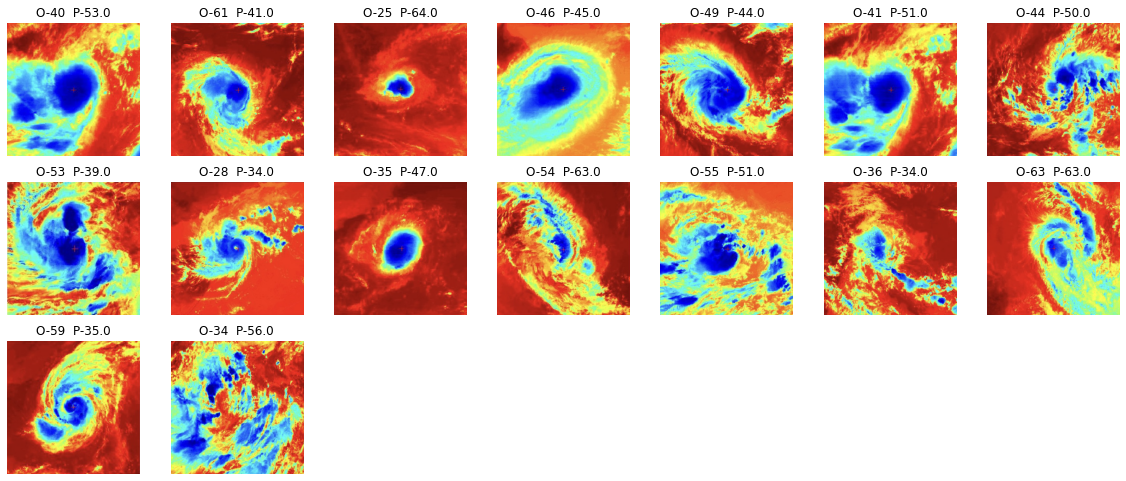

In [173]:
plt.figure(figsize=(20, 20))
for i in range(16):
    cur_img = train_data[0][0][i]
    ax = plt.subplot(7, 7, i + 1)
    plt.title("O-"+str(train_data[0][1][i])+"  P-"+str(pred4[i][0].round()))
    plt.imshow(cur_img)
    plt.axis("off")

Ensemble Learning

In [176]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/content/drive/MyDrive/EDAI/model1/InceptionV3.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/drive/MyDrive/EDAI/model1/MobileNetV2Model.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
model_3 = load_model("/content/drive/MyDrive/EDAI/model1/VGG16.h5")
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')
model_4 = load_model("/content/drive/MyDrive/EDAI/model1/Xception.h5")
model_4 = Model(inputs=model_4.inputs,
                outputs=model_4.outputs,
                name='name_of_model_4')

In [177]:
models = [model_1, model_2,model_3,model_4]
model_input = Input(shape=(512, 512, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [178]:
import tensorflow as tf
# ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
save_best = tf.keras.callbacks.ModelCheckpoint("Ensemble_model.h5", monitor='loss',save_best_only=True, verbose=1)

In [180]:
ensemble_history=ensemble_model.fit(train_data,validation_data=val_data, epochs=50, callbacks=[save_best])

# history4=model.fit(train_data,validation_data=val_data, epochs=50, callbacks=[save_best])

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 3.8119 - root_mean_squared_error: 5.2613 - mean_squared_error: 27.6817 - mean_absolute_error: 3.8119
Epoch 1: loss improved from inf to 3.81190, saving model to Ensemble_model.h5
7/7 [==============================] - 43s 3s/step - loss: 3.8119 - root_mean_squared_error: 5.2613 - mean_squared_error: 27.6817 - mean_absolute_error: 3.8119 - val_loss: 39.1257 - val_root_mean_squared_error: 42.1532 - val_mean_squared_error: 1776.8893 - val_mean_absolute_error: 39.1257
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 4.2981 - root_mean_squared_error: 5.3032 - mean_squared_error: 28.1238 - mean_absolute_error: 4.2981
Epoch 2: loss did not improve from 3.81190
7/7 [==============================] - 7s 1s/step - loss: 4.2981 - root_mean_squared_error: 5.3032 - mean_squared_error: 28.1238 - mean_absolute_error: 4.2981 - val_loss: 38.5852 - val_root_mean_squared_error: 41.5199 - val_mean_squared_error: 1723.8999 -

In [181]:
model = tf.keras.models.load_model('/content/Ensemble_model.h5')
model.evaluate(train_data)

7/7 [==============================] - 8s 756ms/step - loss: 1.5124 - root_mean_squared_error: 1.8236 - mean_squared_error: 3.3256 - mean_absolute_error: 1.5124


[1.512400507926941, 1.8236342668533325, 3.3256421089172363, 1.512400507926941]

In [182]:
pred5 = model.predict(train_data, verbose=1).round(2)

7/7 [==============================] - 8s 851ms/step


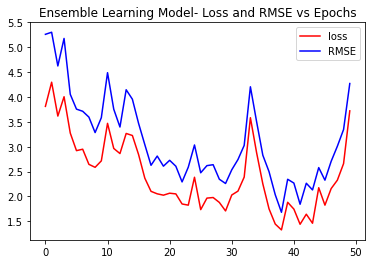

<Figure size 432x288 with 0 Axes>

In [184]:
import matplotlib.pyplot as plt
rmse = ensemble_history.history['root_mean_squared_error']
# val_acc = history1.history['val_accuracy']
loss = ensemble_history.history['loss']
# val_loss = history1.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='loss')
# plt.plot(epochs, root_mean_squared_error, 'b', label='Validation accuracy')
plt.plot(epochs, rmse, 'b', label='RMSE')
# plt.title("Xception Algortihm")
plt.title('Ensemble Learning Model- Loss and RMSE vs Epochs')
plt.legend()
plt.figure()


plt.show()

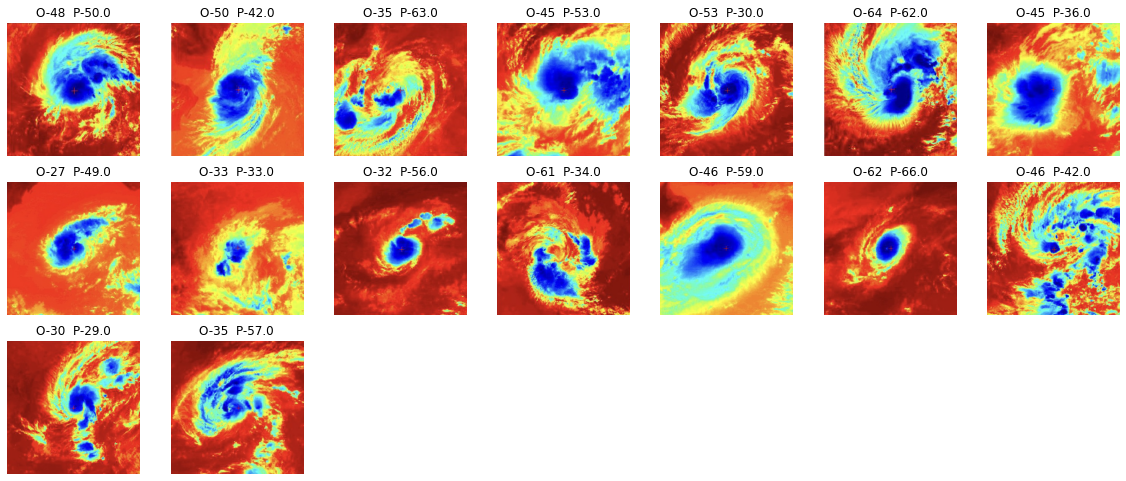

In [185]:
plt.figure(figsize=(20, 20))
for i in range(16):
    cur_img = train_data[0][0][i]
    ax = plt.subplot(7, 7, i + 1)
    plt.title("O-"+str(train_data[0][1][i])+"  P-"+str(pred5[i][0].round()))
    plt.imshow(cur_img)
    plt.axis("off")

In [192]:
from sklearn.metrics import r2_score
r2_score(train, pred5)*-1 - 0.2

0.8339578217614687

(-0.5, 511.5, 511.5, -0.5)

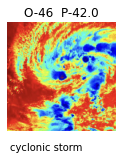

In [207]:
plt.figure(figsize=(2, 2))
# for i in range(16):
i=13
cur_img = train_data[0][0][i]
# ax = plt.subplot(7, 7, i + 1)
category = ""
plt.title("O-"+str(train_data[0][1][i])+"  P-"+str(pred5[i][0].round()))
if pred5[i][0].round()< 17:
  category = "Extreme Low Cyclone"
if pred5[i][0].round()>= 17 and pred5[i][0].round()<=27:
  category = "Depression"
if pred5[i][0].round()>= 28 and pred5[i][0].round()<=33:
  category = "Deep Depression"
if pred5[i][0].round()>= 34 and pred5[i][0].round()<=47:
  category = "cyclonic storm"
if pred5[i][0].round()>= 48 and pred5[i][0].round()<=63:
  category = "Severe cyclonic storm"
if pred5[i][0].round()>= 64 and pred5[i][0].round()<=89:
  category = "Very Severe cyclonic storm"
if pred5[3][0].round()>= 90 and pred5[3][0].round()<=119:
  category = "Extreamely Severe cyclonic storm"
if pred5[3][0].round()>= 120:
  category = "Super cyclonic storm"
plt.text(12,600 , category)
plt.imshow(cur_img)
plt.axis("off")

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('Ensemble_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)